<a href="https://colab.research.google.com/github/mterion/tensorflow-1-public/blob/main/C4/W2/ungraded_labs/C4_W2_Lab_3_deep_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

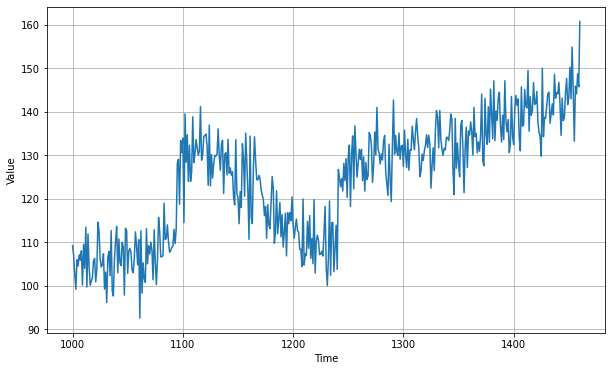

In [4]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series) # Dataset to create some data
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # Size of the window / shift overt time / drop remainder to have all windows with same nr of items
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # Put this into a list so we can use it with ML
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1])) # Split the data into features/labels = split everything but the last one with :-1 then the last one itself with -1: / then shuffle before ttraining
  dataset = dataset.batch(batch_size).prefetch(1) # Will batch the data into set of 32
  return dataset

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


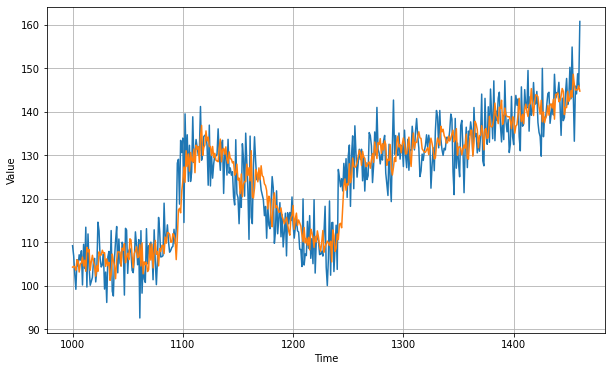

In [8]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.6134715

In [24]:
# Same code but with learning rate optimization
## With callbacks which will adjust the lr over each epochs

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

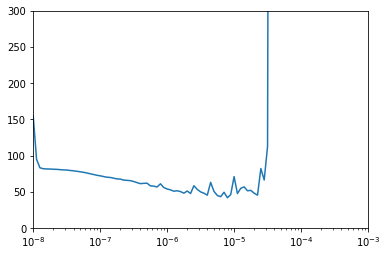

In [25]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])
## See that best seem to be 2 notches to the left of 10-5 -> so approximately 10-6
### So will say that it lr isnot 1e-8, but 1e-6

In [18]:
# Using the new adjusted lr with 500 epochs
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

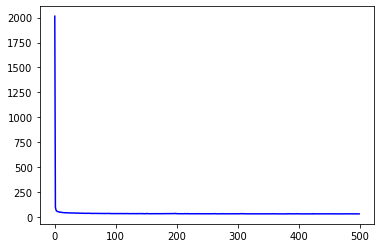

In [20]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()
# Can see how loss progress over training time with adjusted lr
## See that falls sharply and then flatten out

[49.904903411865234, 47.62957000732422, 46.87921142578125, 46.17586135864258, 46.25468444824219, 45.10599136352539, 44.235382080078125, 44.2928352355957, 44.953025817871094, 43.54664993286133, 43.64252471923828, 42.801326751708984, 42.93864059448242, 43.42008972167969, 42.135032653808594, 42.47380065917969, 41.577117919921875, 41.36956787109375, 40.946739196777344, 40.853782653808594, 41.21693420410156, 42.11423110961914, 41.77692794799805, 40.41530990600586, 40.421512603759766, 40.65566635131836, 40.01447296142578, 41.90843963623047, 40.51253128051758, 39.871036529541016, 40.27254104614258, 38.908531188964844, 39.217010498046875, 39.43973159790039, 39.694679260253906, 39.002838134765625, 38.85476303100586, 38.67382049560547, 38.59284973144531, 39.138362884521484, 38.16651153564453, 38.22372817993164, 37.97582244873047, 38.18092727661133, 39.481327056884766, 38.38764953613281, 38.20011901855469, 38.71400451660156, 37.726593017578125, 37.467857360839844, 37.25926971435547, 37.1497344970

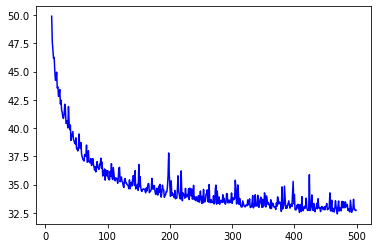

In [21]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()
# By removing the first 10 epochs, we see that lr is constantly decreasing = learning well
## See that still decreasing after 500 epochs, so still learning

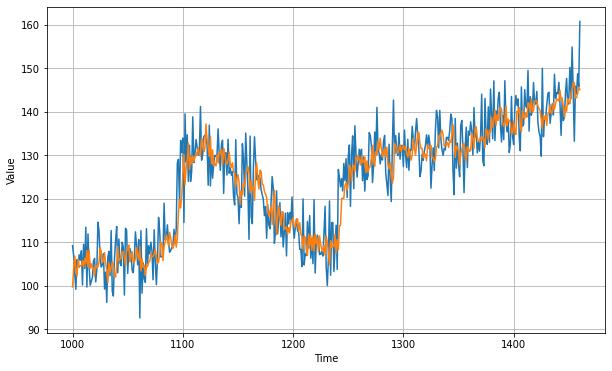

In [22]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# Slight Improvement

4.5851655